# Import Packages

In [1]:
# Import packages
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from copy import deepcopy

In [2]:
logs_df = pd.read_csv("../Data Cleaning/cleaned_dataset.csv")
# logs_df = pd.read_csv("cleaned_dataset.csv")
# logs_df = pd.read_csv("cleaned_dataset_all.csv")
logs_df

,SEX,AGE,RXASP,RXHEP,FDEAD,FDENNIS,FRECOVER,RXHEP_1,TREATMENT,REWARD_BERNOULLI,REWARD_CATEGORICAL,REWARD_VALUE (BER),REWARD_VALUE (CAT)
0,M,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,1
1,F,YOUNG,Y,L,N,Y,N,L,4,Alive,Alive and still dependent,1,3
2,F,YOUNG,Y,N,N,N,N,N,3,Alive,Alive and recovered,1,4
3,F,OLD,N,L,Y,NaN,NaN,L,2,Dead,Dead,0,1
4,M,OLD,N,N,N,Y,N,N,1,Alive,Alive and still dependent,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,F,YOUNG,N,N,N,N,N,N,1,Alive,Alive and recovered,1,4
2496,M,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,1
2497,M,OLD,N,N,Y,NaN,NaN,N,1,Dead,Dead,0,1
2498,M,YOUNG,N,N,N,N,N,N,1,Alive,Alive and recovered,1,4


In [3]:
logs_df_1 = sum(logs_df[logs_df["TREATMENT"] == 1]["REWARD_VALUE (BER)"]) / logs_df["TREATMENT"].value_counts()[1]
logs_df_2 = sum(logs_df[logs_df["TREATMENT"] == 2]["REWARD_VALUE (BER)"]) / logs_df["TREATMENT"].value_counts()[2]
logs_df_3 = sum(logs_df[logs_df["TREATMENT"] == 3]["REWARD_VALUE (BER)"]) / logs_df["TREATMENT"].value_counts()[3]
logs_df_4 = sum(logs_df[logs_df["TREATMENT"] == 4]["REWARD_VALUE (BER)"]) / logs_df["TREATMENT"].value_counts()[4]
print(logs_df_1)
print(logs_df_2)
print(logs_df_3)
print(logs_df_4)

0.7567886658795749
0.7218390804597701
0.765142150803461
0.784841075794621


In [4]:
logs_df_1 = sum(logs_df[logs_df["TREATMENT"] == 1]["REWARD_VALUE (CAT)"]) / logs_df["TREATMENT"].value_counts()[1]
logs_df_2 = sum(logs_df[logs_df["TREATMENT"] == 2]["REWARD_VALUE (CAT)"]) / logs_df["TREATMENT"].value_counts()[2]
logs_df_3 = sum(logs_df[logs_df["TREATMENT"] == 3]["REWARD_VALUE (CAT)"]) / logs_df["TREATMENT"].value_counts()[3]
logs_df_4 = sum(logs_df[logs_df["TREATMENT"] == 4]["REWARD_VALUE (CAT)"]) / logs_df["TREATMENT"].value_counts()[4]
print(logs_df_1)
print(logs_df_2)
print(logs_df_3)
print(logs_df_4)

def get_reward_prob(df):
    rewards_list = ['Alive and still dependent', 'Alive and recovered', 'Dead', 'Alive with unknown status']
    probs_list = []
    for i in range(4):
        prob = sum(df[df["REWARD_CATEGORICAL"] == rewards_list[i]]["REWARD_VALUE (CAT)"]) / sum(df["REWARD_CATEGORICAL"].value_counts())
        probs_list.append(prob)
    probs_list = [x/sum(probs_list) for x in probs_list]
    return probs_list

treatment_1 = logs_df[logs_df["TREATMENT"] == 1]
treatment_2 = logs_df[logs_df["TREATMENT"] == 2]
treatment_3 = logs_df[logs_df["TREATMENT"] == 3]
treatment_4 = logs_df[logs_df["TREATMENT"] == 4]

treatment_1_probs = get_reward_prob(treatment_1)
treatment_2_probs = get_reward_prob(treatment_2)
treatment_3_probs = get_reward_prob(treatment_3)
treatment_4_probs = get_reward_prob(treatment_4)

print(treatment_1_probs)
print(treatment_2_probs)
print(treatment_3_probs)
print(treatment_4_probs)

2.855962219598583
2.7701149425287355
2.8788627935723117
2.9168704156479217
[0.4179412980570484, 0.49111202976436547, 0.08515915667631253, 0.005787515502273667]
[0.4182572614107884, 0.4780082987551867, 0.10041493775933609, 0.003319502074688796]
[0.42378703306139975, 0.49119793902962655, 0.08158007728638901, 0.0034349506225848005]
[0.44509639564124054, 0.47946353730092206, 0.07376362112321877, 0.0016764459346186086]


# Arms

In [5]:
# Define the BernoulliArm class
class BernoulliArm():
    def __init__(self, p):
        self.p = p
        
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

In [6]:
# Define the CategoricalArm class
class CategoricalArm():
    def __init__(self, p):
        self.p = p
        
    def draw(self):
        probabilities = self.p
        rewards_list = ['Dead','Alive and still dependent', 'Alive with unknown status', 'Alive and recovered']
        rewards_dict = {'Dead': 0, 'Alive and still dependent': 1, 'Alive with unknown status': 2, 'Alive and recovered': 3}
        category = np.random.choice(4, p=probabilities)
        reward_cat = rewards_list[category]
        reward = rewards_dict[reward_cat]
        return reward

# Algorithms
* Epsilon Greedy
* Softmax

## Epsilon Greedy

In [7]:
# Implement the EpsilonGreedy class
class EpsilonGreedy():
    
    def __init__(self, epsilon, counts, values): 
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
        return 
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        return
    
    def select_arm(self):
        if random.random() > self.epsilon:
            m = max(self.values)
            return self.values.index(m)
        else:
            return random.randrange(len(self.values))
        
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In [8]:
# Implement the EpsilonGreedyCat class
# class EpsilonGreedyCategorical():
    
#     def __init__(self, epsilon, counts, values, total): 
#         self.epsilon = epsilon
#         self.counts = counts
#         #[{"reward1": count1, "reward2": count2}, {..}]
#         self.values = values
#         #["reward1", "reward3, ...]
#         self.total = total
#         return 
    
#     def initialize(self, n_arms):
#         keyList = ['Dead','Alive and still dependent','Alive and recovered', 'Alive with unknown status']
#         arm_dict = dict(zip(keyList, [0]*len(keyList)))
#         self.counts = [arm_dict for item in range(n_arms)]
#         self.values = [0.0 for item in range(n_arms)]
#         self.total = [0 for item in range(n_arms)]
#         return
    
#     def select_arm(self):
#         if random.random() > self.epsilon:
#             m = max(self.total)
#             return self.total.index(m)
#         else:
#             return random.randrange(len(self.values))
        
#     def update(self, chosen_arm, reward):
#         self.total[chosen_arm] = self.total[chosen_arm] + 1
#         indv_dict = self.counts[chosen_arm]
#         indv_dict[reward] += 1
#         sum_values = self.total[chosen_arm]
#         new_dict = indv_dict
#         for x, y in new_dict.items():
#             new_dict[x] = y/sum_values
#         max_reward = max(new_dict, key=new_dict.get)
#         self.values[chosen_arm] = max_reward
#         return

## Softmax

In [9]:
class Softmax():
    
    def __init__(self, temperature, counts, values):
        self.temperature = temperature
        self.counts = counts
        self.values = values
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        return
        
    def select_arm(self):
        z=sum([math.exp(v/self.temperature) for v in self.values])
        probs=[math.exp(v/self.temperature)/z for v in self.values]
        current_choice = np.random.choice(n_arms, p=probs)
        return current_choice
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        return

In [10]:
# class SoftmaxCategorical():
    
#     def __init__(self, temperature, counts, values, total):
#         self.temperature = temperature
#         self.counts = counts
#         self.values = values
#         self.total = total
#         return
    
#     def initialize(self, n_arms):
#         keyList = ['Dead','Alive and still dependent','Alive and recovered', 'Alive with unknown status']
#         arm_dict = dict(zip(keyList, [0]*len(keyList)))
#         self.counts = [arm_dict for item in range(n_arms)]
#         self.values = ['' for item in range(n_arms)]
#         self.total = [0 for item in range(n_arms)]
#         return
    
#     # HOW WILL THIS WORK
#     def select_arm(self):
#         z=sum([math.exp(v/self.temperature) for v in self.values])
#         probs=[math.exp(v/self.temperature)/z for v in self.values]
#         current_choice = np.random.choice(n_arms, p=probs)
#         return current_choice
    
#     def update(self, chosen_arm, reward):
#         self.total[chosen_arm] = self.total[chosen_arm] + 1
#         indv_dict = self.counts[chosen_arm]
#         indv_dict[reward] += 1
#         sum_values = self.total[chosen_arm]
#         new_dict = indv_dict
#         for x, y in new_dict.items():
#             new_dict[x] = y/sum_values
#         max_reward = max(new_dict, key=new_dict.get)
#         self.values[chosen_arm] = max_reward
#         return

# Simulation and Tuning

In [11]:
# Implement Simulation Test
def test_algorithm(algo, arms, n_sims, horizon):
    chosen_arms = [0 for i in range(n_sims * horizon)]
    rewards = [0 for i in range(n_sims * horizon)]
    cumulative_rewards = [0 for i in range(n_sims * horizon)]
    sim_rounds = [0 for i in range(n_sims * horizon)]
    time_steps = [0 for i in range(n_sims * horizon)]
    
    for sim in range(n_sims):
        sim = sim + 1
        algo.initialize(len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim-1) * horizon + t - 1
            sim_rounds[index] = sim
            time_steps[index] = t
            
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            reward = arms[chosen_arm].draw()
            rewards[index] = reward
            
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward 
            
            algo.update(chosen_arm, reward)

    return (sim_rounds, time_steps, chosen_arms, rewards, cumulative_rewards)

In [12]:
# Implement Simulation Test
# def test_algorithm_categorical(algo, arms, n_sims, horizon):
#     chosen_arms = [0 for i in range(n_sims * horizon)]
#     rewards = ['' for i in range(n_sims * horizon)]

#     reward_categories = ['Dead','Alive and still dependent','Alive and recovered', 'Alive with unknown status']
#     reward_values = {'Dead': -2,'Alive and still dependent': -1,'Alive with unknown status': 1, 'Alive and recovered': 2}
#     cum_rewards = {category: 0 for category in reward_categories}
#     cumulative_rewards = [cum_rewards for i in range(n_sims * horizon)]
    
#     sim_rounds = [0 for i in range(n_sims * horizon)]
#     time_steps = [0 for i in range(n_sims * horizon)]
    
#     for sim in range(n_sims):
#         sim = sim + 1
#         algo.initialize(len(arms))
        
#         for t in range(horizon):
#             t = t + 1
#             index = (sim-1) * horizon + t - 1
#             sim_rounds[index] = sim
#             time_steps[index] = t
            
#             chosen_arm = algo.select_arm()
#             chosen_arms[index] = chosen_arm
#             reward = arms[chosen_arm].draw()
#             rewards[index] = reward_values[reward]

#             if t == 1:
#                 cum_rewards_new = deepcopy(cum_rewards)
#                 cum_rewards_new[reward] = reward_values[reward]
#                 cumulative_rewards[index] = cum_rewards_new
#             else:
#                 prev = deepcopy(cumulative_rewards[index - 1])
#                 prev[reward] = prev[reward] + reward_values[reward]
#                 cumulative_rewards[index] = prev
            
#             algo.update(chosen_arm, reward)

#     return (sim_rounds, time_steps, chosen_arms, rewards, cumulative_rewards)

## Initialise for Bernoulli Distribution

In [13]:
random.seed(4014) # to make sure that I can regenerate the results

# Initialise probabilities
success_probabilities_ber = [0.5, 0.2, 0.6, 0.8]

no_of_treatments = len(success_probabilities_ber)
test_treatments = list(map(lambda mu: BernoulliArm(mu), success_probabilities_ber))

# Number of arms
n_arms = len(success_probabilities_ber)

# Initialise no of simulations
no_of_simulations = 1000

# Initialise no of steps (no of patients)
no_of_steps = 2500

# Epsilon values
epsilon_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Temperature values
tau_values = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9]

# Create all_results dataframe
all_results_epsilon_ber = pd.DataFrame(columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"])
all_results_softmax_ber = pd.DataFrame(columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"])

## Initialise for Categorical Distribution

In [14]:
random.seed(4014) # to make sure that I can regenerate the results

# Initialise probabilities
success_probabilities_cat = [0.6, 0.3, 0.7, 0.9]

treatment_probabilities = [treatment_1_probs, treatment_2_probs, treatment_3_probs, treatment_4_probs]

no_of_treatments_cat = len(treatment_probabilities)
test_treatments_cat = list(map(lambda mu: CategoricalArm(mu), treatment_probabilities))

# Number of arms
n_arms = len(success_probabilities_cat)

# Initialise no of simulations
no_of_simulations = 1000

# Initialise no of steps (no of patients)
no_of_steps = 2500

# Epsilon values
epsilon_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Temperature values
tau_values = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9]

# Create all_results dataframe
all_results_epsilon_cat = pd.DataFrame(columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"])
all_results_softmax_cat = pd.DataFrame(columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"])

## Epsilon Greedy

### Bernoulli Rewards

In [15]:
# Loop to simulate
for epsilon in epsilon_values:
    eg_algo = EpsilonGreedy(epsilon, [], [])
    eg_algo.initialize(n_arms)
    results_epsilon = pd.DataFrame(test_algorithm(eg_algo, test_treatments, no_of_simulations, no_of_steps)).transpose()
    results_epsilon.columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"]
    results_epsilon["epsilon"] = epsilon
    all_results_epsilon_ber = pd.concat([all_results_epsilon_ber, results_epsilon])

In [16]:
all_results_epsilon_ber

,n_sim,n_step,chosen_treatment,rewards,cumulative_rewards,epsilon
0,1.0,1.0,0.0,1.0,1.0,0.1
1,1.0,2.0,0.0,0.0,1.0,0.1
2,1.0,3.0,0.0,0.0,1.0,0.1
3,1.0,4.0,0.0,0.0,1.0,0.1
4,1.0,5.0,0.0,1.0,2.0,0.1
...,...,...,...,...,...,...
2499995,1000.0,2496.0,1.0,0.0,1386.0,0.9
2499996,1000.0,2497.0,3.0,0.0,1386.0,0.9
2499997,1000.0,2498.0,0.0,1.0,1387.0,0.9
2499998,1000.0,2499.0,1.0,0.0,1387.0,0.9


In [17]:
# If chosen_treatment = to the treatment with highest click_probability, return 1 else 0
all_results_epsilon_ber['if_best_treatment'] = np.where(all_results_epsilon_ber['chosen_treatment'] == success_probabilities_ber.index(max(success_probabilities_ber)), 1, 0)

# Group by epsilon and n_step,
results_plot_epsilon_ber = all_results_epsilon_ber.groupby(['epsilon', 'n_step'], as_index = False).aggregate({'if_best_treatment': lambda x: x.sum() / float(x.count()), "rewards":"mean", "cumulative_rewards":"mean"})

In [18]:
results_plot_epsilon_ber

,epsilon,n_step,if_best_treatment,rewards,cumulative_rewards
0,0.1,1.0,0.025,0.495,0.495
1,0.1,2.0,0.045,0.521,1.016
2,0.1,3.0,0.057,0.506,1.522
3,0.1,4.0,0.078,0.545,2.067
4,0.1,5.0,0.090,0.507,2.574
...,...,...,...,...,...
22495,0.9,2496.0,0.321,0.557,1377.705
22496,0.9,2497.0,0.319,0.533,1378.238
22497,0.9,2498.0,0.324,0.548,1378.786
22498,0.9,2499.0,0.307,0.527,1379.313


Text(0.5, 1.0, 'The probability of choosing the best treatment')

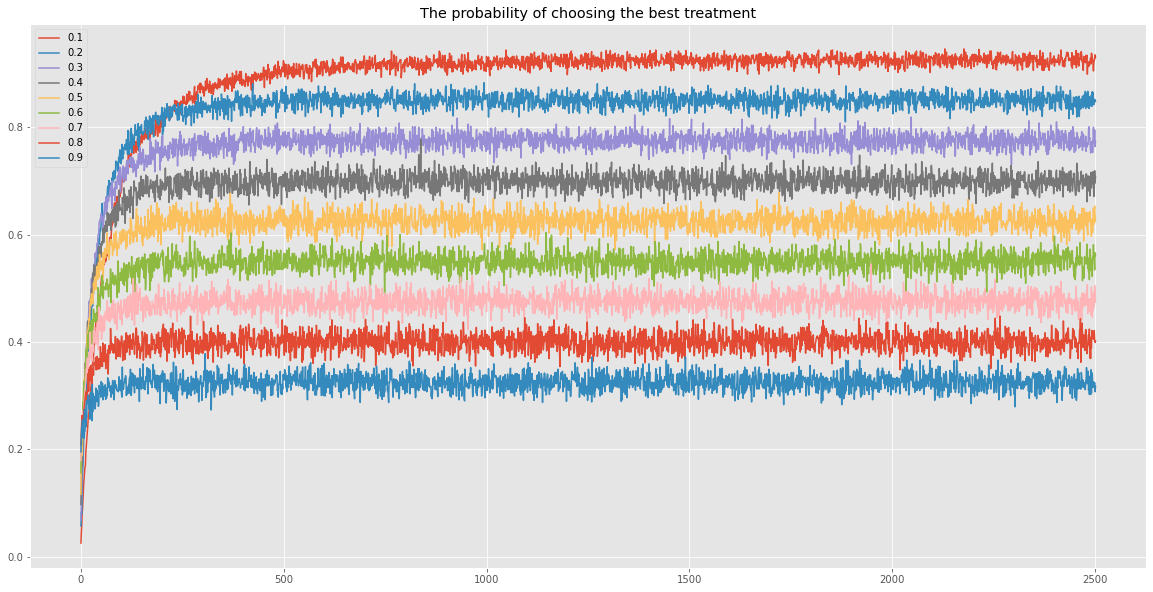

In [19]:
plt.style.use('ggplot')

# Plot the probability of choosing the best movie
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for epsilon in results_plot_epsilon_ber['epsilon'].unique():
    results_epsilon_ber = results_plot_epsilon_ber[results_plot_epsilon_ber['epsilon'] == epsilon]
    ax.plot(results_epsilon_ber['n_step'], results_epsilon_ber['if_best_treatment'], label = str(epsilon))

plt.legend() 
plt.title("The probability of choosing the best treatment")

Text(0.5, 1.0, 'Average rewards at each time step')

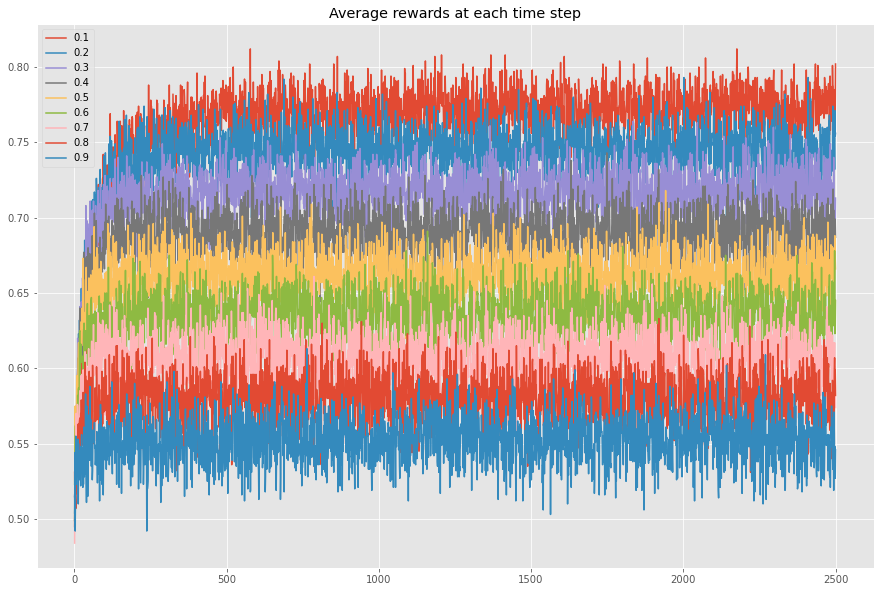

In [20]:
# plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for epsilon in results_plot_epsilon_ber['epsilon'].unique():
    results_epsilon_ber = results_plot_epsilon_ber[results_plot_epsilon_ber['epsilon'] == epsilon]
    ax.plot(results_epsilon_ber['n_step'], results_epsilon_ber['rewards'],label=str(epsilon))

plt.legend()
plt.title("Average rewards at each time step")

In [21]:
# Determine the cumulative reward at 1000 time step
results_plot_epsilon_ber[results_plot_epsilon_ber["n_step"] == 2500].sort_values(by=["cumulative_rewards"], ascending = False)

,epsilon,n_step,if_best_treatment,rewards,cumulative_rewards
2499,0.1,2500.0,0.930,0.802,1909.862
4999,0.2,2500.0,0.848,0.756,1853.029
7499,0.3,2500.0,0.774,0.713,1787.103
9999,0.4,2500.0,0.708,0.687,1719.558
12499,0.5,2500.0,0.624,0.666,1652.193
14999,0.6,2500.0,0.561,0.645,1584.342
17499,0.7,2500.0,0.474,0.574,1517.353
19999,0.8,2500.0,0.401,0.582,1449.495
22499,0.9,2500.0,0.317,0.546,1379.859


Text(0.5, 1.0, 'Cumulative rewards at each step')

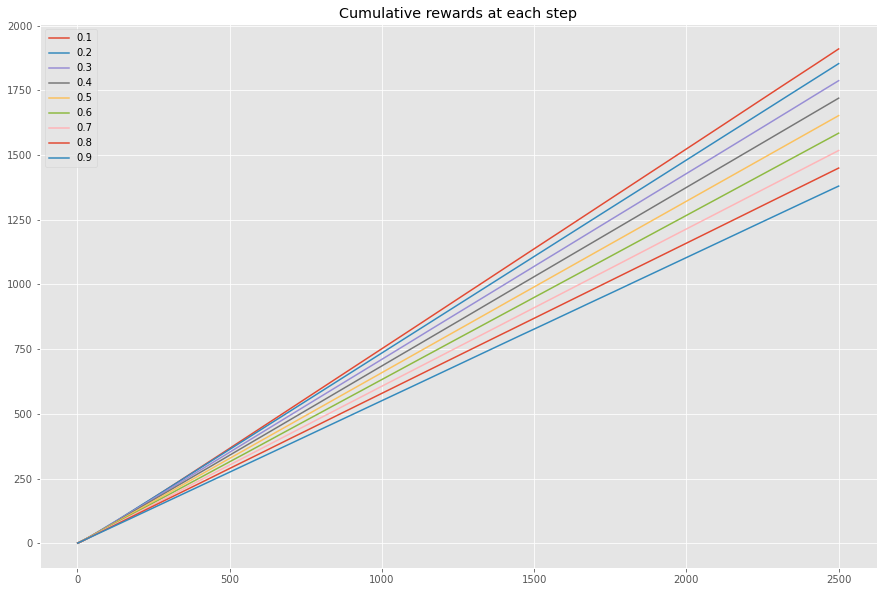

In [22]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for epsilon in results_plot_epsilon_ber['epsilon'].unique():
    results_epsilon_ber = results_plot_epsilon_ber[results_plot_epsilon_ber['epsilon'] == epsilon]
    ax.plot(results_epsilon_ber['n_step'], results_epsilon_ber['cumulative_rewards'], label = str(epsilon))

plt.legend()
plt.title("Cumulative rewards at each step")

### Categorical Rewards

In [23]:
# Loop to simulate
for epsilon in epsilon_values:
    eg_algo = EpsilonGreedy(epsilon, [], [])
    eg_algo.initialize(n_arms)
    results_epsilon = pd.DataFrame(test_algorithm(eg_algo, test_treatments_cat, no_of_simulations, no_of_steps)).transpose()
    results_epsilon.columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"]
    results_epsilon["epsilon"] = epsilon
    all_results_epsilon_cat = pd.concat([all_results_epsilon_cat, results_epsilon])

In [24]:
all_results_epsilon_cat

,n_sim,n_step,chosen_treatment,rewards,cumulative_rewards,epsilon
0,1,1,0,1,1,0.1
1,1,2,0,1,2,0.1
2,1,3,0,2,4,0.1
3,1,4,0,0,4,0.1
4,1,5,0,0,4,0.1
...,...,...,...,...,...,...
2499995,1000,2496,1,1,1604,0.9
2499996,1000,2497,3,1,1605,0.9
2499997,1000,2498,3,0,1605,0.9
2499998,1000,2499,0,1,1606,0.9


In [25]:
# If chosen_treatment = to the treatment with highest click_probability, return 1 else 0
all_results_epsilon_cat['if_best_treatment'] = np.where(all_results_epsilon_cat['chosen_treatment'] == success_probabilities_cat.index(max(success_probabilities_cat)), 1, 0)

# Group by epsilon and n_step,
results_plot_epsilon_cat = all_results_epsilon_cat.groupby(['epsilon', 'n_step'], as_index = False).aggregate({'if_best_treatment': lambda x: x.sum() / float(x.count()), "rewards":"mean", "cumulative_rewards":"mean"})

In [26]:
results_plot_epsilon_cat

,epsilon,n_step,if_best_treatment,rewards,cumulative_rewards
0,0.1,1,0.027,0.681,0.681
1,0.1,2,0.036,0.678,1.359
2,0.1,3,0.040,0.682,2.041
3,0.1,4,0.054,0.630,2.671
4,0.1,5,0.061,0.704,3.375
...,...,...,...,...,...
22495,0.9,2496,0.219,0.682,1664.131
22496,0.9,2497,0.240,0.661,1664.792
22497,0.9,2498,0.209,0.662,1665.454
22498,0.9,2499,0.217,0.655,1666.109


Text(0.5, 1.0, 'The probability of choosing the best treatment')

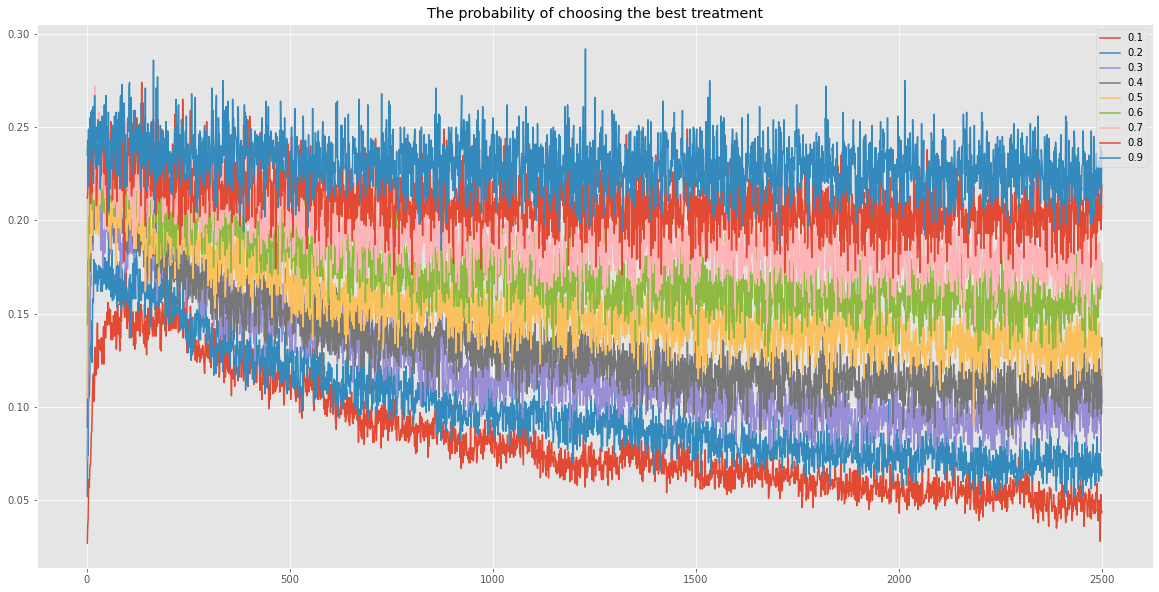

In [27]:
plt.style.use('ggplot')

# Plot the probability of choosing the best tretament
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for epsilon in results_plot_epsilon_cat['epsilon'].unique():
    results_epsilon_cat = results_plot_epsilon_cat[results_plot_epsilon_cat['epsilon'] == epsilon]
    ax.plot(results_epsilon_cat['n_step'], results_epsilon_cat['if_best_treatment'], label = str(epsilon))

plt.legend() 
plt.title("The probability of choosing the best treatment")

Text(0.5, 1.0, 'Average rewards at each time step')

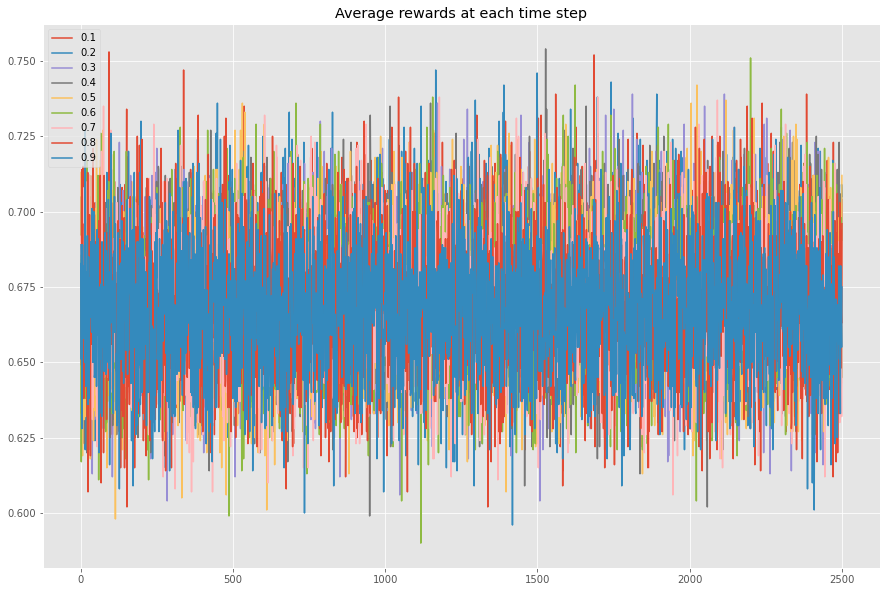

In [28]:
# plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for epsilon in results_plot_epsilon_cat['epsilon'].unique():
    results_epsilon_cat = results_plot_epsilon_cat[results_plot_epsilon_cat['epsilon'] == epsilon]
    ax.plot(results_epsilon_cat['n_step'], results_epsilon_cat['rewards'],label=str(epsilon))

plt.legend()
plt.title("Average rewards at each time step")

In [29]:
# Determine the cumulative reward at 1000 time step
results_plot_epsilon_cat[results_plot_epsilon_cat["n_step"] == 2500].sort_values(by=["cumulative_rewards"], ascending = False)

,epsilon,n_step,if_best_treatment,rewards,cumulative_rewards
2499,0.1,2500,0.044,0.704,1689.662
4999,0.2,2500,0.066,0.705,1688.809
9999,0.4,2500,0.137,0.672,1684.779
7499,0.3,2500,0.102,0.678,1682.689
12499,0.5,2500,0.117,0.712,1678.438
14999,0.6,2500,0.177,0.645,1677.214
17499,0.7,2500,0.165,0.690,1674.081
19999,0.8,2500,0.219,0.696,1671.067
22499,0.9,2500,0.237,0.675,1666.784


Text(0.5, 1.0, 'Cumulative rewards at each step')

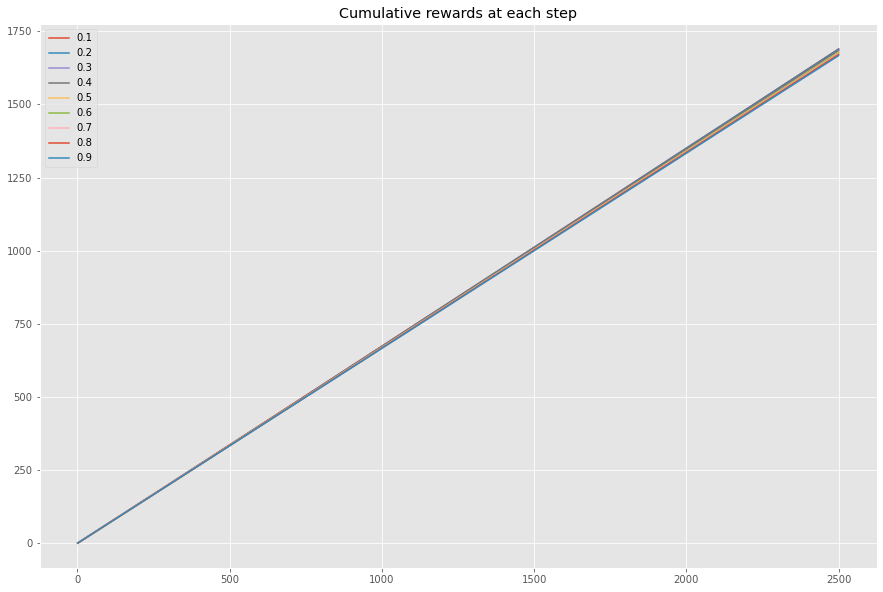

In [30]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for epsilon in results_plot_epsilon_cat['epsilon'].unique():
    results_epsilon_cat = results_plot_epsilon_cat[results_plot_epsilon_cat['epsilon'] == epsilon]
    ax.plot(results_epsilon_cat['n_step'], results_epsilon_cat['cumulative_rewards'], label = str(epsilon))

plt.legend()
plt.title("Cumulative rewards at each step")

Text(0.5, 1.0, 'Cumulative rewards at each step')

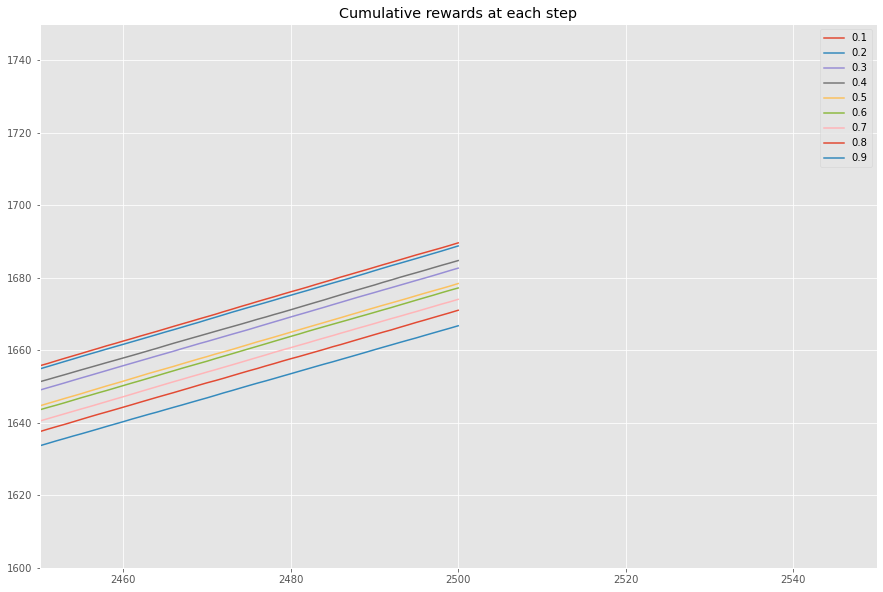

In [31]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for epsilon in results_plot_epsilon_cat['epsilon'].unique():
    results_epsilon_cat = results_plot_epsilon_cat[results_plot_epsilon_cat['epsilon'] == epsilon]
    ax.plot(results_epsilon_cat['n_step'], results_epsilon_cat['cumulative_rewards'], label = str(epsilon))

plt.xlim(2450, 2550)
plt.ylim(1600, 1750)
plt.legend()
plt.title("Cumulative rewards at each step")

## Softmax

### Bernoulli Rewards

In [32]:
for temperature in tau_values:
    algo = Softmax(temperature, [], [])
    algo.initialize(n_arms)
    results_softmax = pd.DataFrame(test_algorithm(algo, test_treatments, no_of_simulations, no_of_steps)).transpose()
    results_softmax.columns=['n_sim','n_step','chosen_treatment','rewards','cumulative_rewards']
    results_softmax['temperature'] = temperature
    all_results_softmax_ber = pd.concat([all_results_softmax_ber, results_softmax])

In [33]:
all_results_softmax_ber

,n_sim,n_step,chosen_treatment,rewards,cumulative_rewards,temperature
0,1.0,1.0,3.0,1.0,1.0,0.01
1,1.0,2.0,3.0,0.0,1.0,0.01
2,1.0,3.0,3.0,1.0,2.0,0.01
3,1.0,4.0,3.0,1.0,3.0,0.01
4,1.0,5.0,3.0,1.0,4.0,0.01
...,...,...,...,...,...,...
2499995,1000.0,2496.0,2.0,1.0,1409.0,0.90
2499996,1000.0,2497.0,3.0,0.0,1409.0,0.90
2499997,1000.0,2498.0,0.0,1.0,1410.0,0.90
2499998,1000.0,2499.0,3.0,0.0,1410.0,0.90


In [34]:
# If chosen_treatment = to the treatment with highest click_probability, return 1 else 0
all_results_softmax_ber['if_best_treatment'] = np.where(all_results_softmax_ber['chosen_treatment'] == success_probabilities_ber.index(max(success_probabilities_ber)), 1, 0)

# Group by epsilon and n_step,
results_plot_softmax_ber = all_results_softmax_ber.groupby(['temperature', 'n_step'], as_index = False).aggregate({'if_best_treatment': lambda x: x.sum() / float(x.count()), "rewards":"mean", "cumulative_rewards":"mean"})

In [35]:
results_plot_softmax_ber

,temperature,n_step,if_best_treatment,rewards,cumulative_rewards
0,0.01,1.0,0.247,0.535,0.535
1,0.01,2.0,0.305,0.568,1.103
2,0.01,3.0,0.338,0.587,1.690
3,0.01,4.0,0.356,0.636,2.326
4,0.01,5.0,0.363,0.581,2.907
...,...,...,...,...,...
19995,0.90,2496.0,0.300,0.570,1433.262
19996,0.90,2497.0,0.331,0.560,1433.822
19997,0.90,2498.0,0.321,0.591,1434.413
19998,0.90,2499.0,0.328,0.611,1435.024


Text(0.5, 1.0, 'The probability of choosing the best treatment')

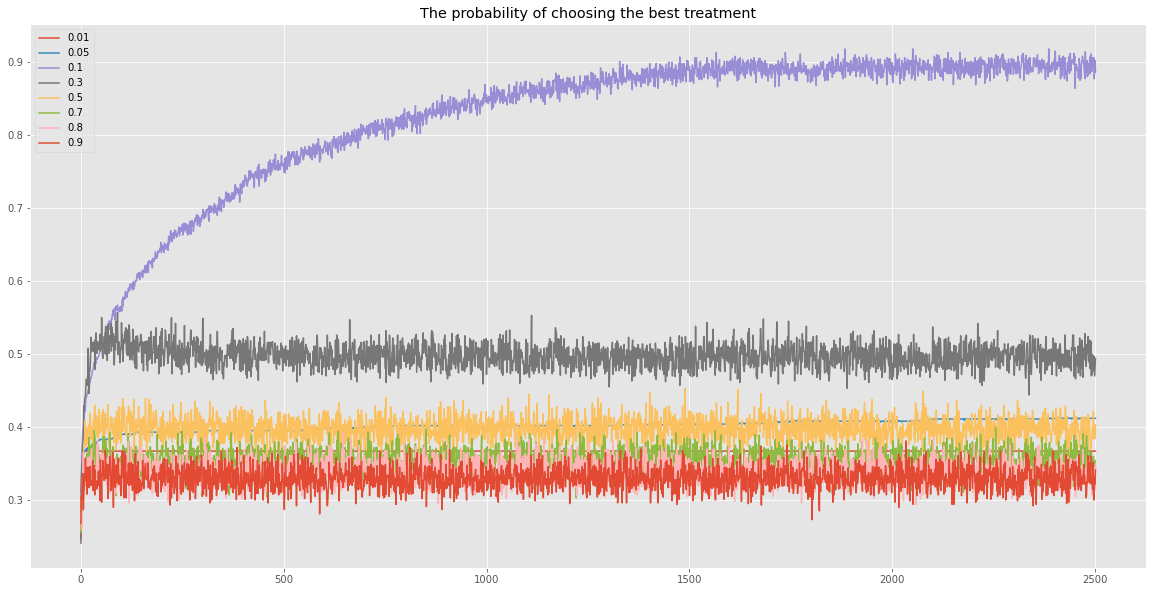

In [36]:
plt.style.use('ggplot')

# Plot the probability of choosing the best movie
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)

for tau in results_plot_softmax_ber['temperature'].unique():
    results_softmax_ber = results_plot_softmax_ber[results_plot_softmax_ber['temperature'] == tau]
    ax.plot(results_softmax_ber['n_step'], results_softmax_ber['if_best_treatment'], label = str(tau))

plt.legend() 
plt.title("The probability of choosing the best treatment")

Text(0.5, 1.0, 'Average rewards at each time step')

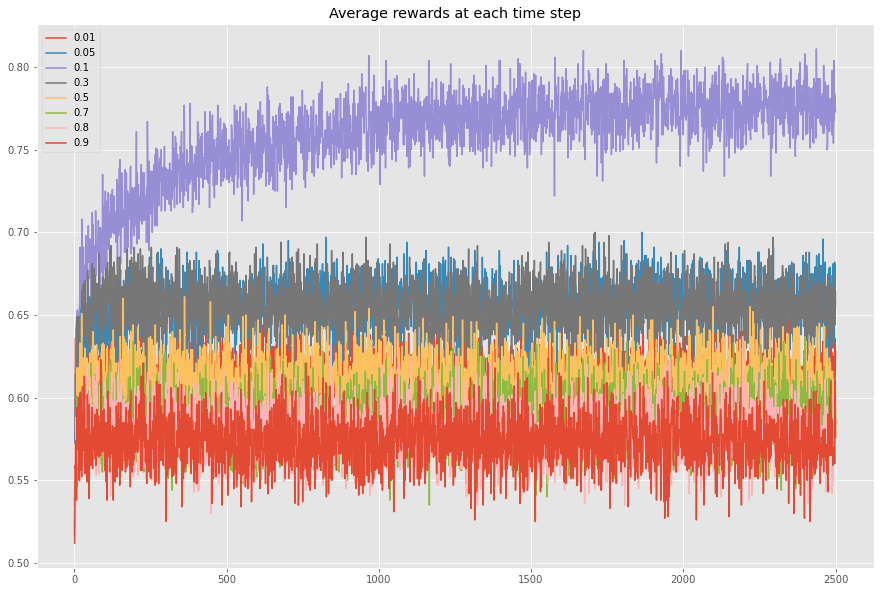

In [37]:
# plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for epsilon in results_plot_softmax_ber['temperature'].unique():
    results_softmax_ber = results_plot_softmax_ber[results_plot_softmax_ber['temperature'] == epsilon]
    ax.plot(results_softmax_ber['n_step'], results_softmax_ber['rewards'],label=str(epsilon))

plt.legend()
plt.title("Average rewards at each time step")

In [38]:
# Determine the cumulative reward at 1000 time step
results_plot_softmax_ber[results_plot_softmax_ber["n_step"] == 2500].sort_values(by=["cumulative_rewards"], ascending = False)

,temperature,n_step,if_best_treatment,rewards,cumulative_rewards
7499,0.10,2500.0,0.886,0.773,1897.356
4999,0.05,2500.0,0.412,0.658,1638.677
9999,0.30,2500.0,0.494,0.664,1636.917
2499,0.01,2500.0,0.367,0.628,1530.561
12499,0.50,2500.0,0.403,0.584,1524.767
14999,0.70,2500.0,0.354,0.576,1469.710
17499,0.80,2500.0,0.348,0.611,1450.427
19999,0.90,2500.0,0.341,0.576,1435.600


Text(0.5, 1.0, 'Cumulative rewards at each step')

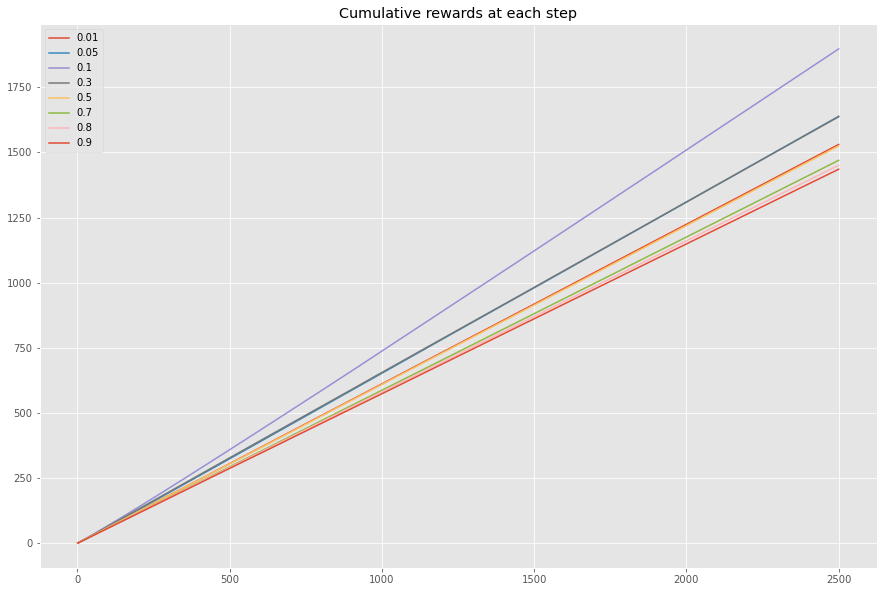

In [39]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for tau in results_plot_softmax_ber['temperature'].unique():
    results_softmax_ber = results_plot_softmax_ber[results_plot_softmax_ber['temperature'] == tau]
    ax.plot(results_softmax_ber['n_step'], results_softmax_ber['cumulative_rewards'], label = str(tau))

plt.legend()
plt.title("Cumulative rewards at each step")

### Categorical Rewards

In [40]:
for temperature in tau_values:
    algo = Softmax(temperature, [], [])
    algo.initialize(n_arms)
    results_softmax = pd.DataFrame(test_algorithm(algo, test_treatments_cat, no_of_simulations, no_of_steps)).transpose()
    results_softmax.columns=['n_sim','n_step','chosen_treatment','rewards','cumulative_rewards']
    results_softmax['temperature'] = temperature
    all_results_softmax_cat = pd.concat([all_results_softmax_cat, results_softmax])

In [41]:
all_results_softmax_cat

,n_sim,n_step,chosen_treatment,rewards,cumulative_rewards,temperature
0,1,1,2,0,0,0.01
1,1,2,1,2,2,0.01
2,1,3,1,0,2,0.01
3,1,4,1,0,2,0.01
4,1,5,1,1,3,0.01
...,...,...,...,...,...,...
2499995,1000,2496,3,1,1727,0.90
2499996,1000,2497,0,1,1728,0.90
2499997,1000,2498,0,0,1728,0.90
2499998,1000,2499,2,0,1728,0.90


In [42]:
# If chosen_treatment = to the treatment with highest click_probability, return 1 else 0
all_results_softmax_cat['if_best_treatment'] = np.where(all_results_softmax_cat['chosen_treatment'] == success_probabilities_cat.index(max(success_probabilities_cat)), 1, 0)

# Group by epsilon and n_step,
results_plot_softmax_cat = all_results_softmax_cat.groupby(['temperature', 'n_step'], as_index = False).aggregate({'if_best_treatment': lambda x: x.sum() / float(x.count()), "rewards":"mean", "cumulative_rewards":"mean"})

In [43]:
results_plot_softmax_cat

,temperature,n_step,if_best_treatment,rewards,cumulative_rewards
0,0.01,1,0.227,0.652,0.652
1,0.01,2,0.235,0.626,1.278
2,0.01,3,0.223,0.668,1.946
3,0.01,4,0.224,0.694,2.640
4,0.01,5,0.230,0.703,3.343
...,...,...,...,...,...
19995,0.90,2496,0.252,0.666,1662.970
19996,0.90,2497,0.212,0.651,1663.621
19997,0.90,2498,0.238,0.669,1664.290
19998,0.90,2499,0.257,0.637,1664.927


Text(0.5, 1.0, 'The probability of choosing the best treatment')

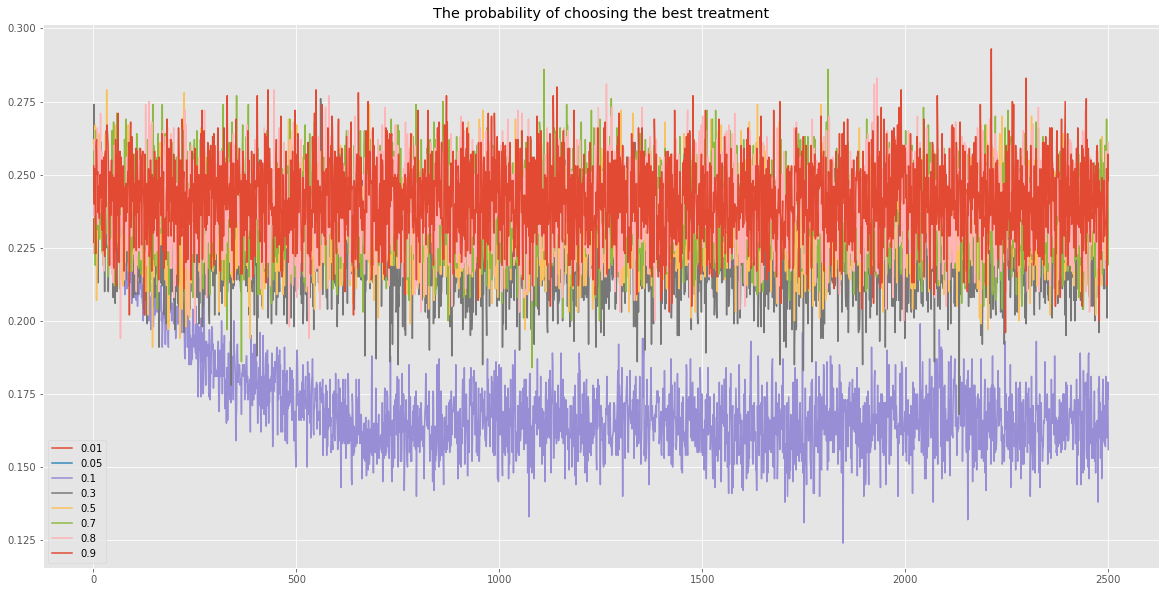

In [44]:
plt.style.use('ggplot')

# Plot the probability of choosing the best movie
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)

for tau in results_plot_softmax_cat['temperature'].unique():
    results_softmax_cat = results_plot_softmax_cat[results_plot_softmax_cat['temperature'] == tau]
    ax.plot(results_softmax_cat['n_step'], results_softmax_cat['if_best_treatment'], label = str(tau))

plt.legend() 
plt.title("The probability of choosing the best treatment")

Text(0.5, 1.0, 'Average rewards at each time step')

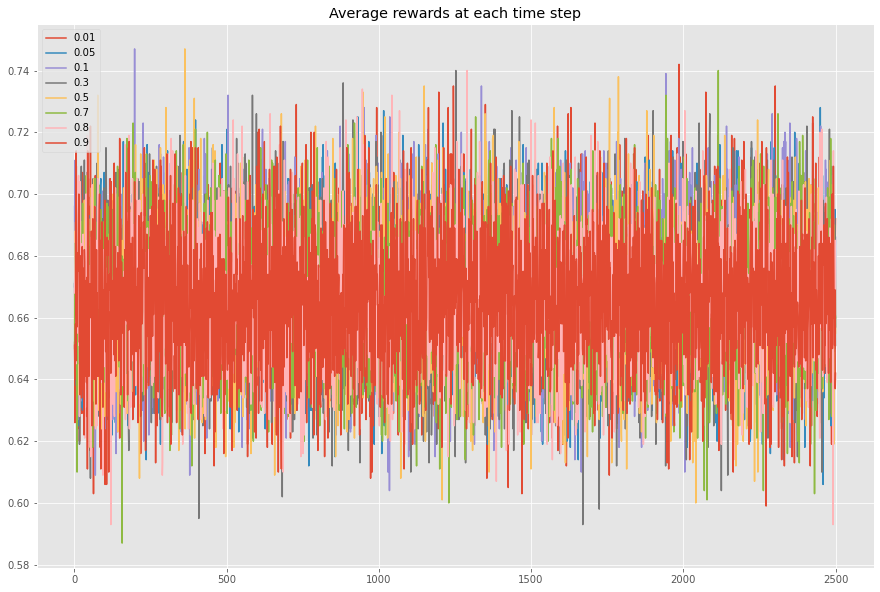

In [45]:
# plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for epsilon in results_plot_softmax_cat['temperature'].unique():
    results_softmax_cat = results_plot_softmax_cat[results_plot_softmax_cat['temperature'] == epsilon]
    ax.plot(results_softmax_cat['n_step'], results_softmax_cat['rewards'],label=str(epsilon))

plt.legend()
plt.title("Average rewards at each time step")

In [46]:
# Determine the cumulative reward at 1000 time step
results_plot_softmax_cat[results_plot_softmax_cat["n_step"] == 2500].sort_values(by=["cumulative_rewards"], ascending = False)

,temperature,n_step,if_best_treatment,rewards,cumulative_rewards
7499,0.10,2500,0.156,0.686,1674.825
2499,0.01,2500,0.231,0.692,1668.040
9999,0.30,2500,0.227,0.651,1667.611
12499,0.50,2500,0.248,0.655,1667.110
4999,0.05,2500,0.229,0.657,1666.948
14999,0.70,2500,0.251,0.660,1666.943
17499,0.80,2500,0.261,0.661,1666.344
19999,0.90,2500,0.248,0.642,1665.569


Text(0.5, 1.0, 'Cumulative rewards at each step')

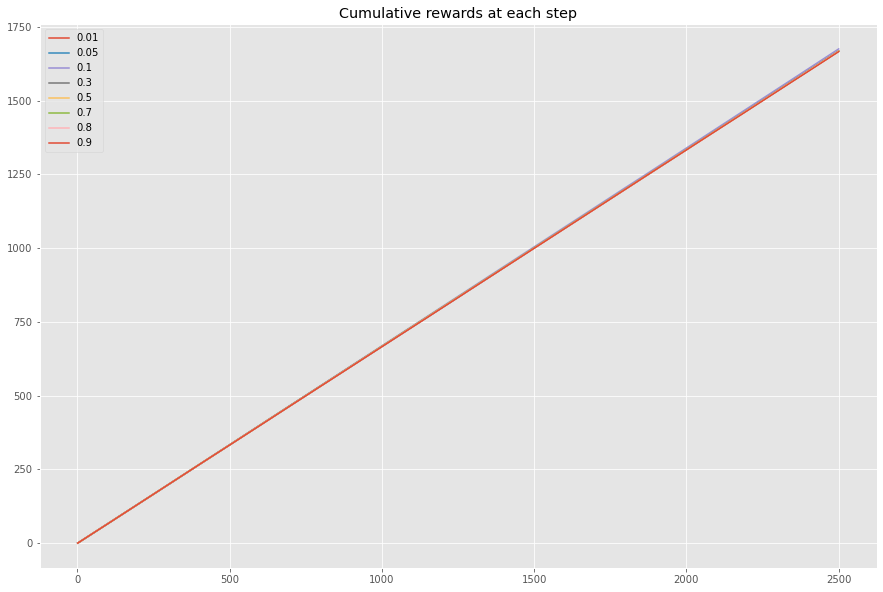

In [47]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for tau in results_plot_softmax_cat['temperature'].unique():
    results_softmax_cat = results_plot_softmax_cat[results_plot_softmax_cat['temperature'] == tau]
    ax.plot(results_softmax_cat['n_step'], results_softmax_cat['cumulative_rewards'], label = str(tau))

plt.legend()
plt.title("Cumulative rewards at each step")

Text(0.5, 1.0, 'Cumulative rewards at each step')

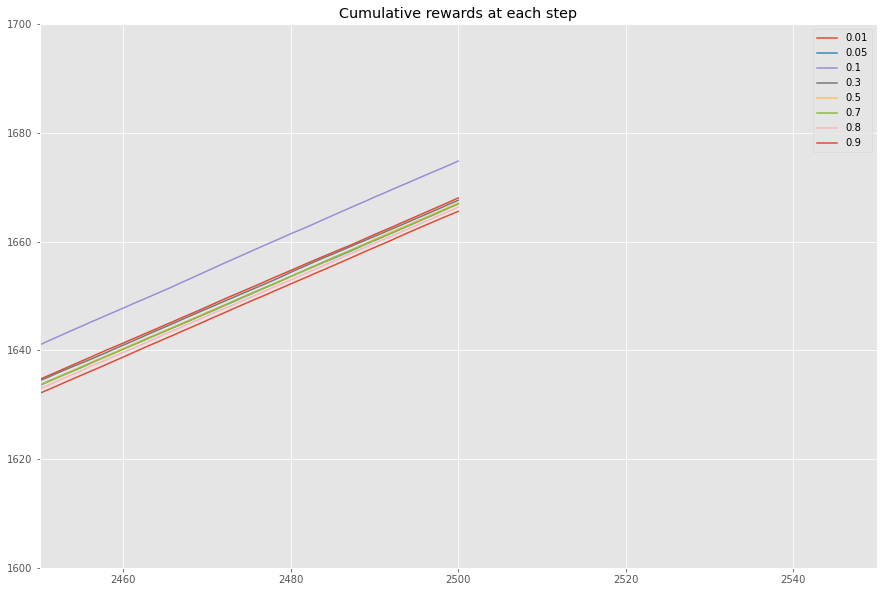

In [48]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for tau in results_plot_softmax_cat['temperature'].unique():
    results_softmax_cat = results_plot_softmax_cat[results_plot_softmax_cat['temperature'] == tau]
    ax.plot(results_softmax_cat['n_step'], results_softmax_cat['cumulative_rewards'], label = str(tau))

plt.xlim(2450, 2550)
plt.ylim(1600, 1700)
plt.legend()
plt.title("Cumulative rewards at each step")